## Лабораторная работа №1. Классификация текстов на реальных данных.

***Задание 1.*** Произведите автоматический сбор информации из Интернет-ресурса по отзывам посетителей.

Данные для классификации текстов были взяты с маркетплейса https://www.wildberries.ru/. Для этого был разработан парсер, в котором используются библиотеки requests и pydantic. Данные на странице сайта подгружаются динамически, используя запросы к API микросервисов(например, к серверам с отзывами, к каталогам товаров и т.п.). С помощью функций библиотеки requests делаются запросы к серверам wildberries, после чего ответ парсится по заданным моделям данных и их атрибутами, указанными в этих моделях, наследованных от базового класса библиотеки pydantic.

В файле `models.py` хранятся модели данных, которые подтягиваются их ответа серверов в формате json, в файле `parser.py` реализован класс парсера. 

Принцип работы парсера следующий:

- Инициализируется класс парсера с ссылкой на какой-либо товар с торговой площадки

- Из ссылки при помощи библиотеки регулярных выражений re парсится id товара

- Делается запрос к северу wildberries, с параметром, полученным на предыдущем шаге, и из запроса извлекается id продавца, товары которого будут потом парситься в цикле

- Создаётся файл csv с колонками `название`, `бренд`, `цена`, `скидка в %`, `цена со скидкой`, `кол-во фото в карточке`, `плюсы`, `минусы`, `наличие фото в отзыве`, `полезно`, `неполезно`, `текст отзыва`, `рейтинг`

- До тех пор, пока сервер возвращает не пустой json-ответ, делаем запрос к нему, получая список товаров продавца постранично, с полями `название`, `бренд`, `цена`, `скидка в %`, `цена со скидкой`, `кол-во фото в карточке`

- Получая список товаров, делаем запрос к серверу с обратной связью - отзывами к одному товару из списка, обрабатываем полученные данные и заносим их в csv файл

В качестве ссылок на товары я случайным образом выбрал товары с площадки из разных категорий разных продавцов, чтобы сделать выборку репрезентативной.

Импортируем заранее все нужные библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

***Задание 2.*** Провидите предпроцессинг данных (очистку данных,
удалите выбросов, пустые значения и т.д). Выполните описательную
статистику.

Прочитаем данные, полученные в результате парсинга. Переименуем исходные названия, чтобы не было путаницы во время кодирования текста.

In [2]:
df = pd.read_csv("dataset.csv")
df.rename(columns={
    "название": "name",
    "бренд": "brand",
    "цена": "price",
    "скидка в %": "sale",
    "цена со скидкой": "price_with_sale",
    "кол-во фото в карточке": "pics",
    "плюсы": "pros",
    "минусы": "cons",
    "наличие фото в отзыве": "hasPhoto",
    "полезно": "useful",
    "неполезно": "unuseful",
    "текст отзыва": "text",
    'рейтинг': 'target',},
    inplace=True)
df.head()

C:\Users\ibasl\AppData\Local\Temp\ipykernel_4836\1056053002.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("dataset.csv")


,name,brand,price,sale,price_with_sale,pics,pros,cons,hasPhoto,useful,unuseful,text,target
0,"Клиппер маникюрный, кусачки для ногтей",Zebo Professional,499.0,59,204.0,5,NaN,NaN,False,0,1,отличные кусачки заточены хорошо со своей зада...,5
1,"Клиппер маникюрный, кусачки для ногтей",Zebo Professional,499.0,59,204.0,5,NaN,NaN,False,0,1,спасибо за качественный товар буду рекомендова...,5
2,"Клиппер маникюрный, кусачки для ногтей",Zebo Professional,499.0,59,204.0,5,NaN,NaN,False,0,0,щипчики хорошо стригут ногти все отлично,5
3,"Клиппер маникюрный, кусачки для ногтей",Zebo Professional,499.0,59,204.0,5,NaN,NaN,False,0,0,хороший набор пришло все целое,5
4,"Клиппер маникюрный, кусачки для ногтей",Zebo Professional,499.0,59,204.0,5,NaN,NaN,False,0,0,получили кусочки пришли быстро и хорошо упаков...,5


Удалим дубликаты в датасете и посмотрим на размер датасета

In [3]:
df.drop_duplicates(inplace=True)
df.shape

(381859, 13)

Посмотрим основную информацию о датасете

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381859 entries, 0 to 461663
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   name             381859 non-null  object 
 1   brand            381857 non-null  object 
 2   price            381859 non-null  float64
 3   sale             381859 non-null  int64  
 4   price_with_sale  381859 non-null  float64
 5   pics             381859 non-null  int64  
 6   pros             0 non-null       float64
 7   cons             0 non-null       float64
 8   hasPhoto         381033 non-null  object 
 9   useful           381859 non-null  int64  
 10  unuseful         381859 non-null  int64  
 11  text             380199 non-null  object 
 12  target           381859 non-null  int64  
dtypes: float64(4), int64(5), object(4)
memory usage: 40.8+ MB


Заменим тип колонки `hasPhoto` на булевый тип

In [5]:
df['hasPhoto'] = df['hasPhoto'].astype(bool)

Посмотрим описательную статистику числовых признаков

In [6]:
df.describe()

,price,sale,price_with_sale,pics,pros,cons,useful,unuseful,target
count,381859.000000,381859.000000,381859.000000,381859.000000,0.0,0.0,381859.000000,381859.000000,381859.000000
mean,8620.201093,58.793353,3335.807565,6.952530,NaN,NaN,1.337533,0.393635,4.517107
std,17832.819749,20.181132,6753.828420,4.154662,NaN,NaN,4.079684,1.848265,1.095853
min,99.000000,0.000000,85.000000,1.000000,NaN,NaN,0.000000,0.000000,1.000000
25%,1500.000000,59.000000,465.000000,4.000000,NaN,NaN,0.000000,0.000000,5.000000
50%,3200.000000,66.000000,1288.000000,6.000000,NaN,NaN,0.000000,0.000000,5.000000
75%,7030.000000,70.000000,3146.000000,9.000000,NaN,NaN,1.000000,0.000000,5.000000
max,629990.000000,93.000000,239396.000000,26.000000,NaN,NaN,332.000000,362.000000,5.000000


Посмотрим описательную статистику нечисловых признаков

In [7]:
df.describe(include=['O'])

,name,brand,text
count,381859,381857,380199
unique,2012,102,201389
top,Ювелирные серьги женские из серебра 925,SOKOLOV,все отлично
freq,9322,178255,716


Посмотрим количество пропусков и визуализируем их

In [8]:
df.isna().sum()

name                    0
brand                   2
price                   0
sale                    0
price_with_sale         0
pics                    0
pros               381859
cons               381859
hasPhoto                0
useful                  0
unuseful                0
text                 1660
target                  0
dtype: int64

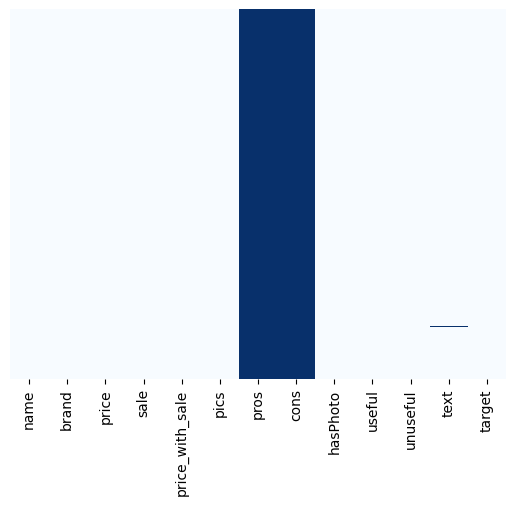

In [9]:
sns.heatmap(df.isna(), yticklabels=False, cbar=False, cmap='Blues');

Видно, что колонки `плюсы` и `минусы` содержат везде пустые значения, удалим их из датасета. Помимо этого удалим остальные встречающиеся пропуски, так как данных у нас очень много - 381 тысяча значений всего и 200 тысяч уникальных текстов.

In [10]:
df.drop(columns=['pros', 'cons'], inplace=True)
df.dropna(inplace=True)
df.drop_duplicates(subset=['text'], inplace=True)
df.shape

(201388, 11)

Посмотрим на корреляцию признаков. Моё предположение - столбцы с обычной ценой и ценой со скидкой коррелируются. Это логично, так как цену со скидкой можно получить линейными преобразованиями столбцов `цена` и `скидка в %`.

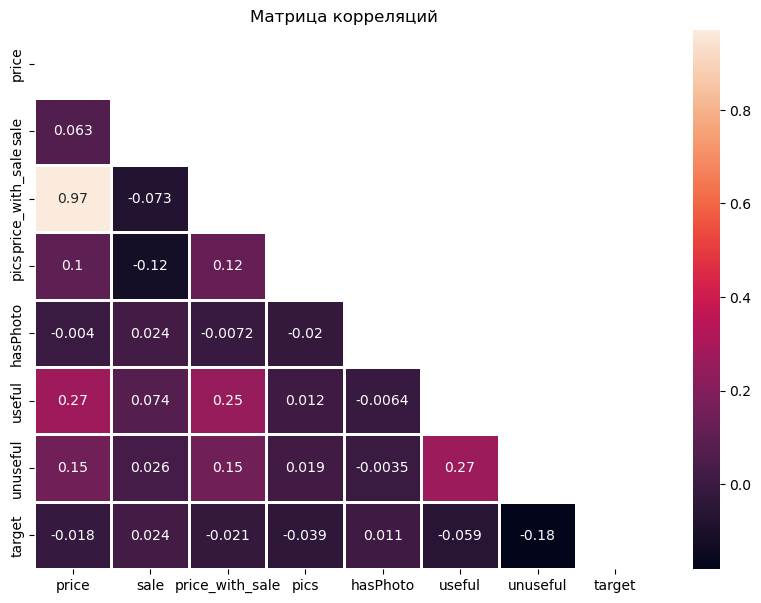

In [11]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize = (10,7))
plt.title('Матрица корреляций')
sns.heatmap(corr,
            mask=mask,
            annot=True,
            fmt='.2g',
            linewidths=2);

Действительно - `цена со скидкой` и `цена` коррелируют со значеним 0.97. Удалим столбец `цена со скидкой`.

In [12]:
df.drop(columns=['price_with_sale'], inplace=True)

Посмотрим на выбросы в числовых данных при помощи графиков "ящик с усами"

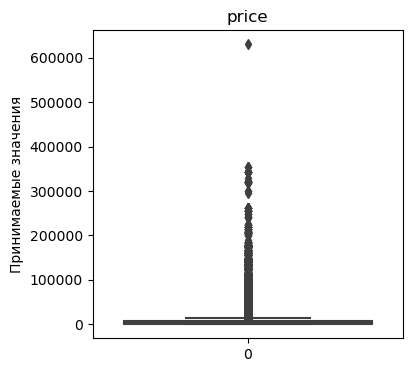

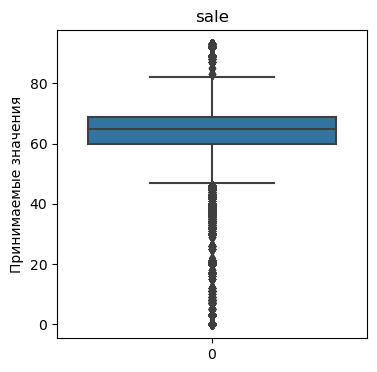

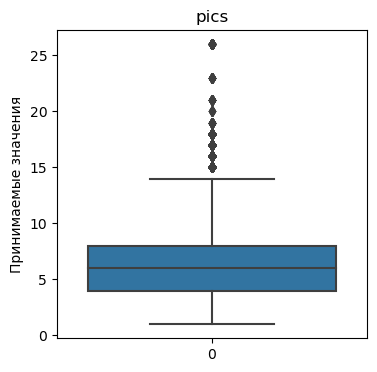

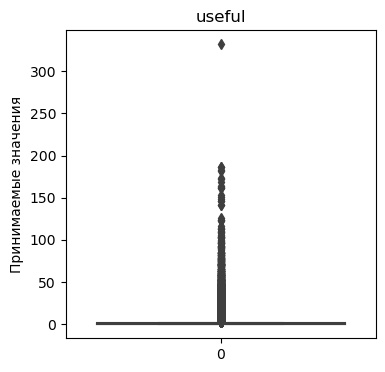

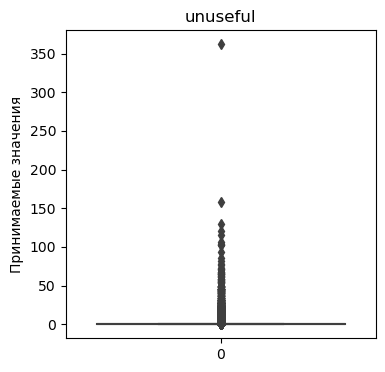

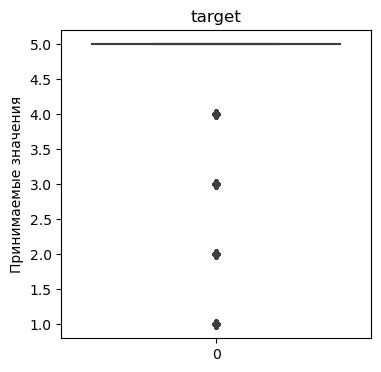

In [13]:
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
for col in numeric_columns:
    plt.figure(figsize=(4,4))
    sns.boxplot(data=df[col])
    plt.title(f'{col}')
    plt.ylabel('Принимаемые значения');

Имеет смысл удалить немного выбросов в колонках `полезно`и `неполезно`, а также удалить большую часть выбросов в столбце `цена`, опираясь на размах значений.

In [14]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)].shape

(174487, 10)

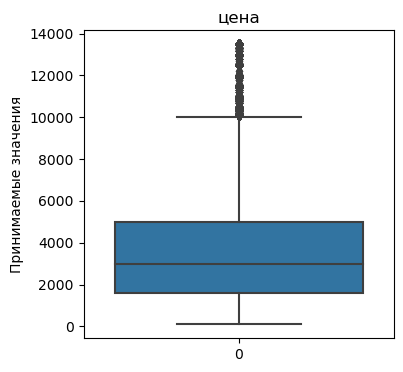

In [15]:
plt.figure(figsize=(4,4))
sns.boxplot(data=df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]['price'])
plt.title(f'цена')
plt.ylabel('Принимаемые значения');

Удалим примерно 12% выбросов по столбцу `цена`. Данных много, это некритично.

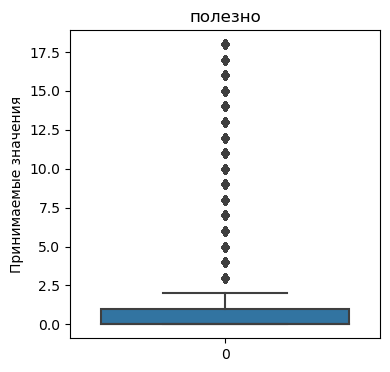

In [16]:
plt.figure(figsize=(4,4))
sns.boxplot(data=df['useful'][df['useful'] < df['useful'].quantile(0.99)])
plt.title(f'полезно')
plt.ylabel('Принимаемые значения');

In [17]:
df['useful'].value_counts()

0      112014
1       40038
2       17313
3        8874
4        5513
        ...  
65          1
108         1
110         1
114         1
90          1
Name: useful, Length: 127, dtype: int64

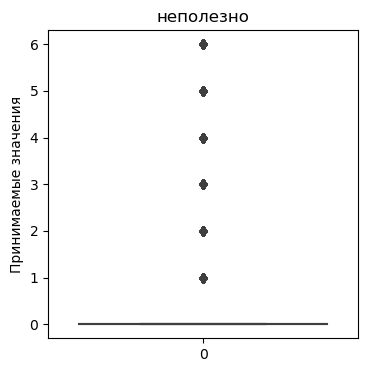

In [18]:
plt.figure(figsize=(4,4))
sns.boxplot(data=df['unuseful'][df['unuseful'] < df['unuseful'].quantile(0.99)])
plt.title(f'неполезно')
plt.ylabel('Принимаемые значения');

In [19]:
df['unuseful'].value_counts()

0      160961
1       24610
2        7409
3        3169
4        1610
        ...  
103         1
63          1
82          1
47          1
72          1
Name: unuseful, Length: 82, dtype: int64

Удалим по 1% в столбцах `неполезно`, `полезно`.

In [20]:
df = df[df['price'] < df['price'].quantile(0.85)]
df = df[df['unuseful'] < df['unuseful'].quantile(0.99)]
df = df[df['useful'] < df['useful'].quantile(0.99)]
df.shape

(166779, 10)

Посмотрим на основную информацию очищенного датасета

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166779 entries, 0 to 461608
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   name      166779 non-null  object 
 1   brand     166779 non-null  object 
 2   price     166779 non-null  float64
 3   sale      166779 non-null  int64  
 4   pics      166779 non-null  int64  
 5   hasPhoto  166779 non-null  bool   
 6   useful    166779 non-null  int64  
 7   unuseful  166779 non-null  int64  
 8   text      166779 non-null  object 
 9   target    166779 non-null  int64  
dtypes: bool(1), float64(1), int64(5), object(3)
memory usage: 12.9+ MB


***Задание 3.*** Провидите анализ предметной области и сделайте несколько практических выводов, исходя из данных. (Визуализация и выводы)

In [22]:
df.head()

,name,brand,price,sale,pics,hasPhoto,useful,unuseful,text,target
0,"Клиппер маникюрный, кусачки для ногтей",Zebo Professional,499.0,59,5,False,0,1,отличные кусачки заточены хорошо со своей зада...,5
1,"Клиппер маникюрный, кусачки для ногтей",Zebo Professional,499.0,59,5,False,0,1,спасибо за качественный товар буду рекомендова...,5
2,"Клиппер маникюрный, кусачки для ногтей",Zebo Professional,499.0,59,5,False,0,0,щипчики хорошо стригут ногти все отлично,5
3,"Клиппер маникюрный, кусачки для ногтей",Zebo Professional,499.0,59,5,False,0,0,хороший набор пришло все целое,5
4,"Клиппер маникюрный, кусачки для ногтей",Zebo Professional,499.0,59,5,False,0,0,получили кусочки пришли быстро и хорошо упаков...,5


__Начнём с метки, которую нужно будет предсказывать - колонка `рейтинг`.__

In [23]:
df['target'].value_counts()

5    134566
4     12441
1      8079
3      7812
2      3881
Name: target, dtype: int64

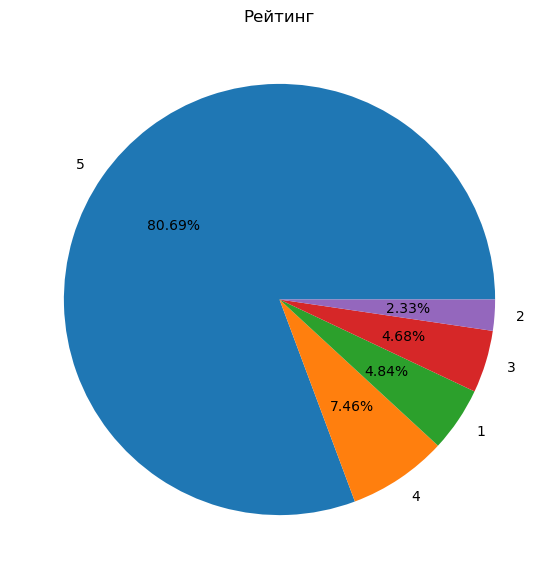

In [24]:
df["target"].value_counts().plot(
                                 kind='pie',
                                 title='Рейтинг',
                                 figsize=(7, 7),
                                 autopct='%.2f%%')
plt.ylabel('');

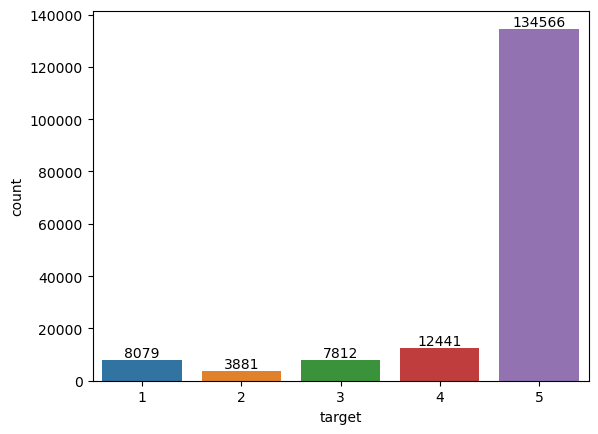

In [25]:
ax = sns.countplot(x='target', data=df)
ax.bar_label(ax.containers[0]);

Классы несбалансированы - слишком много "5" и слишком мало остальных оценок, их в 4 раза меньше. Так как данных много, сделаем undersampling. Каждого класса будет по 3800 - этого хватит, чтобы наша модель имела хорошие обобщающие свойства.

Кроме этого можно сделать вывод, что в 4 из 5 случаях покупатель удовлетворён приобретённым товаром, что является хорошим показателем.

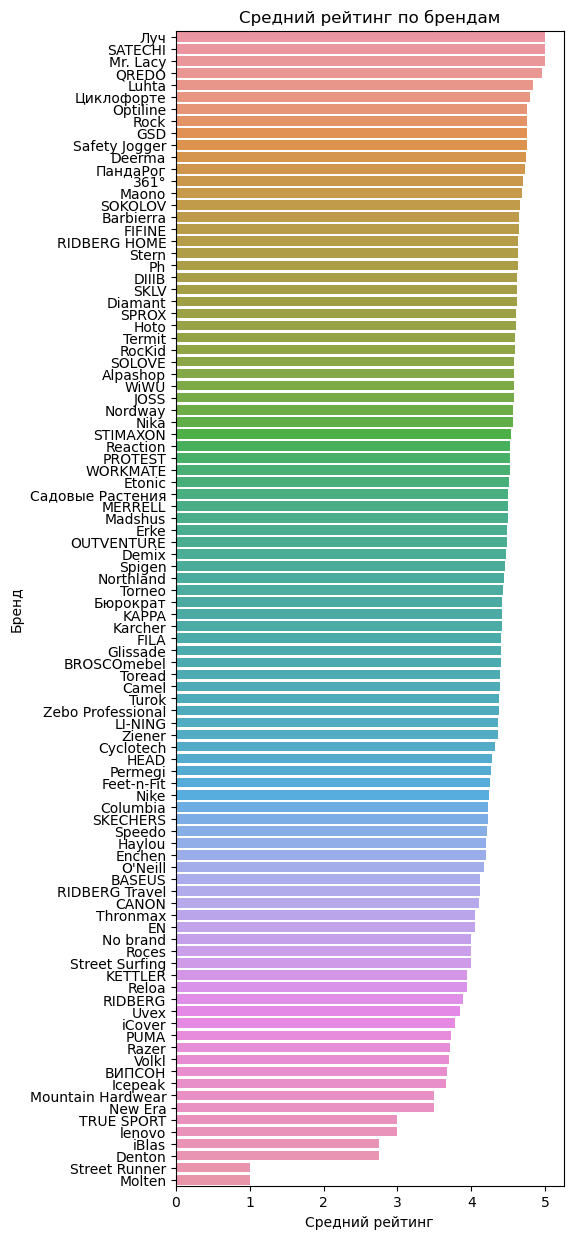

In [26]:
avg_rate_by_brand = pd.DataFrame(df.groupby('brand')['target'].mean())\
                                    .reset_index()\
                                    .sort_values(by='target', ascending=False)

plt.figure(figsize=(5, 15))
sns.barplot(x='target', y='brand', data=avg_rate_by_brand, orient='h')
plt.xlabel('Средний рейтинг')
plt.ylabel('Бренд')
plt.title('Средний рейтинг по брендам')
plt.show()

Большинство брендов держат марку - средняя оценка 4 и выше, но есть и недобросовестные, которые продают товары плохого качества, у которых оценка 3 и ниже, но таких производителей всего 6.

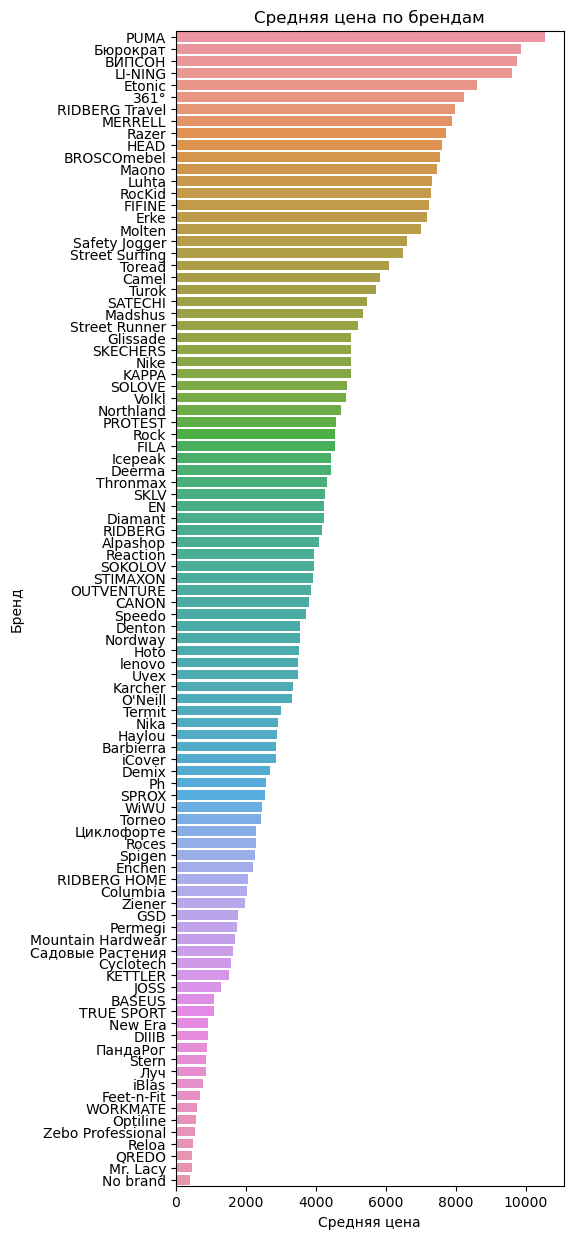

In [27]:
avg_price_by_brand = pd.DataFrame(df.groupby('brand')['price'].mean())\
                                    .reset_index()\
                                    .sort_values(by='price', ascending=False)

plt.figure(figsize=(5, 15))
sns.barplot(x='price', y='brand', data=avg_price_by_brand, orient='h')
plt.xlabel('Средняя цена')
plt.ylabel('Бренд')
plt.title('Средняя цена по брендам')
plt.show()

Большая часть товаров различных брендов продаётся по средней цене до ~5000 рублей.

Так же можно отметить, что замыкающая тройка брендов по среднему рейтингу имеет цену на товары в 4-6 тысяч рублей, т.е. за относительно немаленькие деньги покупатели получают ужасный товар.

__Теперь посмотрим на столбец `наличие фото в отзыве`.__

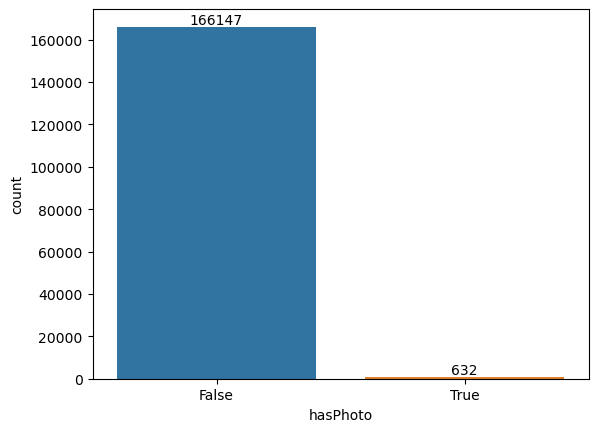

In [28]:
ax = sns.countplot(x='hasPhoto', data=df)
ax.bar_label(ax.containers[0]);

Вывод: подавляющее большинство пользователей предпочитает оставлять отзывы без фотографий.

__Столбец `скидка`__

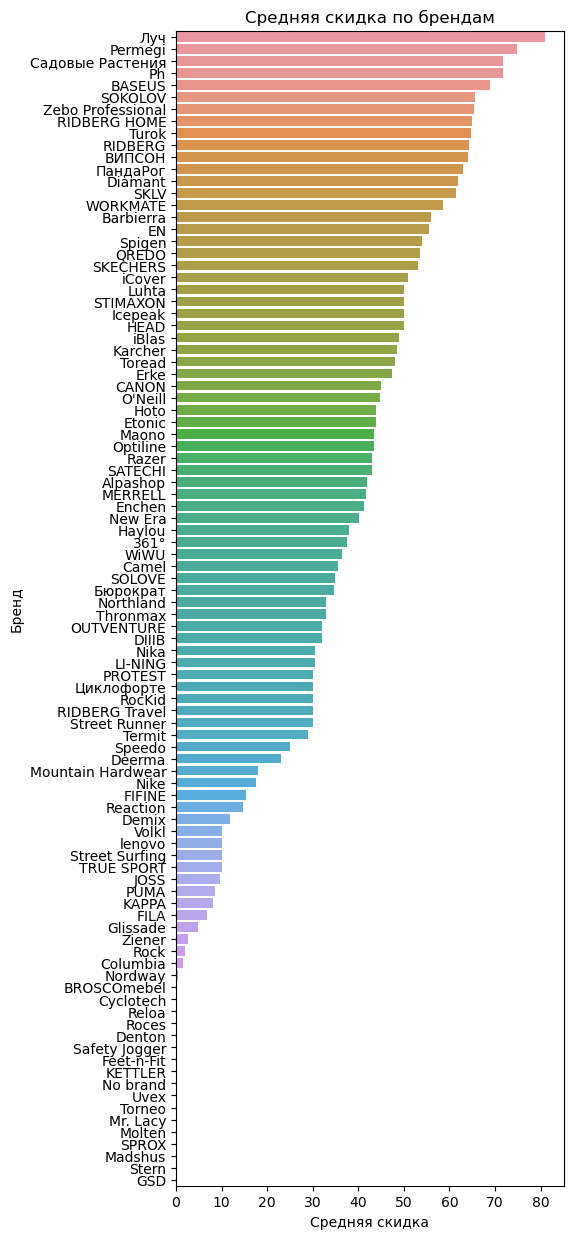

In [29]:
avg_sale_by_brand = pd.DataFrame(df.groupby('brand')['sale'].mean())\
                                    .reset_index()\
                                    .sort_values(by='sale', ascending=False)

plt.figure(figsize=(5, 15))
sns.barplot(x='sale', y='brand', data=avg_sale_by_brand, orient='h')
plt.xlabel('Средняя скидка')
plt.ylabel('Бренд')
plt.title('Средняя скидка по брендам')
plt.show()

Примерно половина брендов имеет скидку более 40%, что несомненно является накруткой, так как это делается для продвижения карточек товаров наверх списка и создания эффекта приобретения выгоды для покупателя. Приблизительно 20%  брендов не имеют скидку.

Рассмотрим столбец `кол-во фото в карточке`

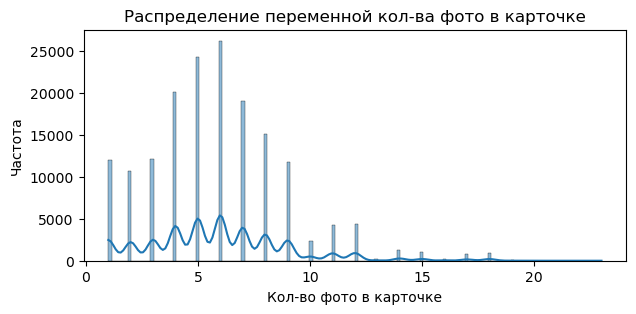

In [30]:
plt.figure(figsize=(7,3))
sns.histplot(x=df['pics'], kde=True)
plt.title('Распределение переменной кол-ва фото в карточке')
plt.xlabel('Кол-во фото в карточке')
plt.ylabel('Частота');

Чаще всего продавцы делают от 1 до 9 фото в карточке. Посмотрим на рейтинг товара в зависимости от количетсва фото в карточке товара

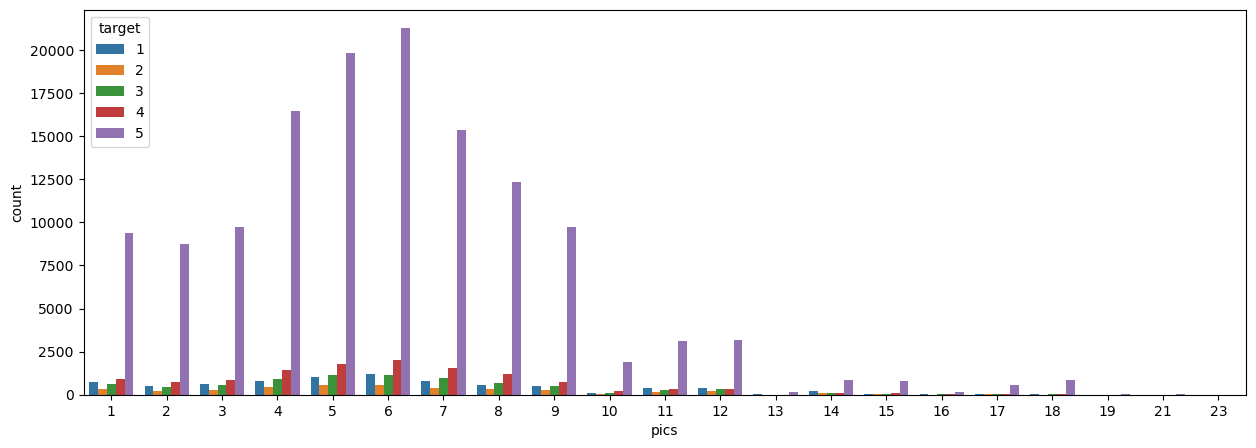

In [31]:
plt.figure(figsize=(15,5))
ax = sns.countplot(x='pics', data=df, hue='target');

Особой зависимости нет - где больше товаров по количеству фотографий, там больше отзывов в целом.

**Задание 4.** Проведите обработку текста. Сравните классы

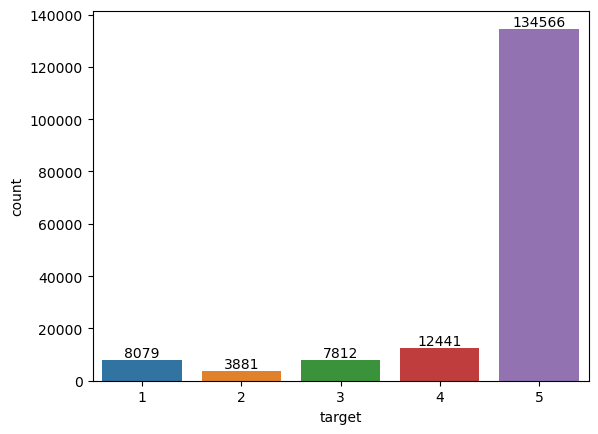

In [32]:
ax = sns.countplot(x='target', data=df)
ax.bar_label(ax.containers[0]);

Как я говорил ранее, классы несбалансированы, и в силу того, что данных много, сделаем undersampoling, возьмём по 3800 отзывов каждого рейтинга и будем учиться на них

**Посмотрим на облако слов**

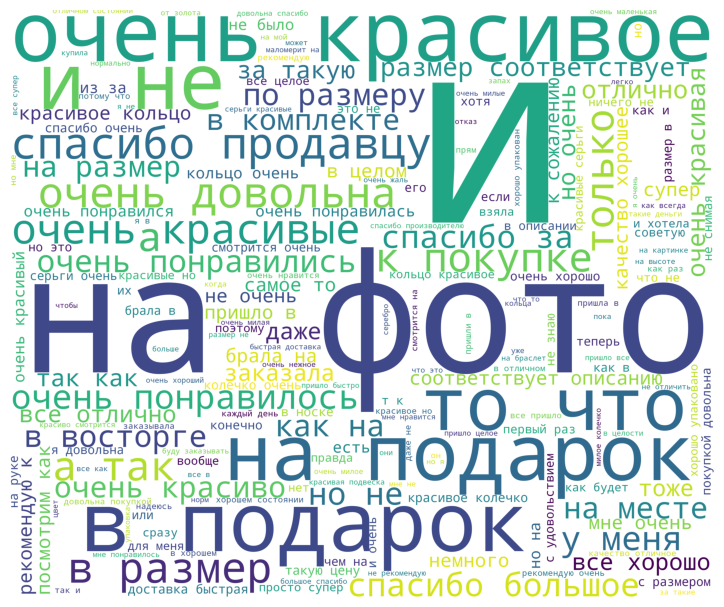

In [33]:
from wordcloud import WordCloud, STOPWORDS


# Получение текстовой строки из списка слов
def str_corpus(corpus):
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus


# Получение списка всех слов в корпусе
def get_corpus(data):
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word)
    return corpus


# Получение облака слов
def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                          stopwords=STOPWORDS,
                          width=3000,
                          height=2500,
                          max_words=200,
                          random_state=42
                          ).generate(str_corpus(corpus))
    return wordCloud


corpus = get_corpus(df['text'].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1);

Уберём стоп-слова и посмотрим на облаков слов. Пунктуация и эмодзи убраны на этапе парсинга

In [34]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
russian_stopwords = stopwords.words("russian")


df['text'] = df['text'].map(lambda x: x.split(' '))
df['text'] = df['text'].map(lambda x: [token for token in x if token not in russian_stopwords\
                                                                  and token != " "])
df['text'] = df['text'].map(lambda x: ' '.join(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ibasl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


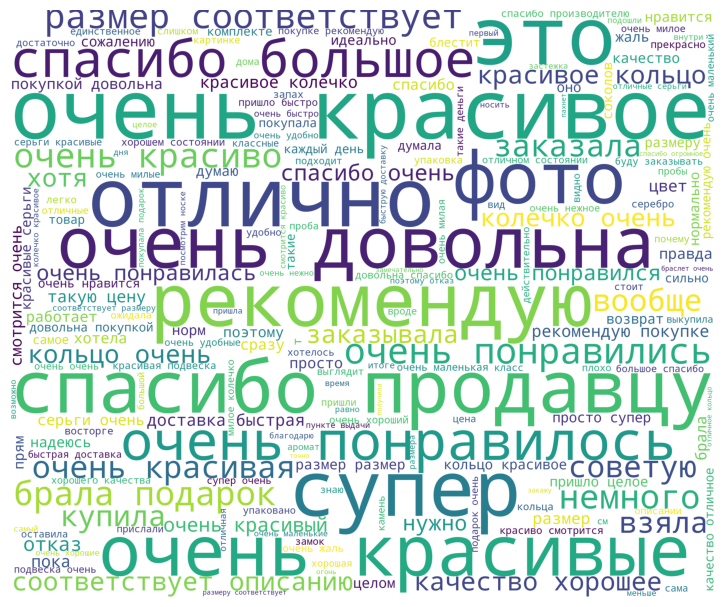

In [35]:
corpus = get_corpus(df['text'].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1);

Много слов положительных, оно и понятно - 80% нашего датасета с отличной оценкой. Сделаем ребалансировку и вновь посмотрим на облако слов.

In [36]:
from imblearn.under_sampling import RandomUnderSampler

X = df.drop('target', axis=1)
y = df['target']

rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

X_resampled, y_resampled = rus.fit_resample(X, y)

In [37]:
y_resampled.value_counts()

1    3881
2    3881
3    3881
4    3881
5    3881
Name: target, dtype: int64

In [38]:
X_resampled.reset_index(drop=True, inplace=True)
y_resampled.reset_index(drop=True, inplace=True)

df = pd.concat([X_resampled, y_resampled], axis=1)

Теперь у нас есть 5 сбалансированных класов. Посмотрим на облако слов

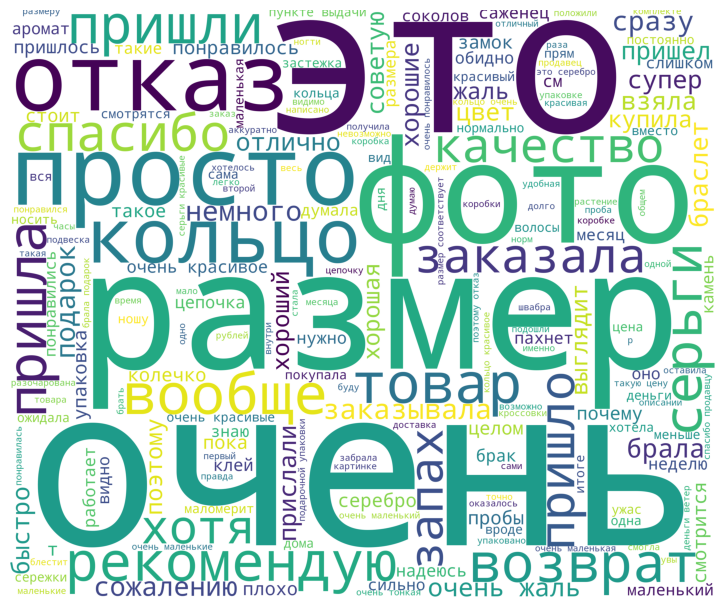

In [39]:
corpus = get_corpus(df['text'].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1);

В силу того, что больше половины датасета составляют отзывы о продукции "Sokolov", то встречается немало слов, связанных с тематикой ювелирных изделий(например, серебро, серьги/серёжки, кольцо и т.п.)

### Обработка данных

Стандартизируем числовые признаки, закодируем категориальные признаки, векторизируем текст

In [40]:
numeric_columns

['price', 'sale', 'pics', 'useful', 'unuseful', 'target']

In [41]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[numeric_columns[:-1]] = scaler.fit_transform(df[numeric_columns[:-1]])

In [42]:
df

,name,brand,price,sale,pics,hasPhoto,useful,unuseful,text,target
0,Шлепанцы Mono,FILA,-0.144880,-2.472030,-0.618441,False,-0.030635,0.600217,пришли абсолютно схожи оригиналом фото китайск...,1
1,Кольцо из серебра,SOKOLOV,0.178815,0.401142,-0.925706,False,0.518779,-0.542338,кольцо пришло согнутое думаю продавцу нужно пе...,1
2,Ювелирный каучуковый шнурок с замком из серебр...,SOKOLOV,0.015126,0.575274,-0.925706,False,1.617607,0.600217,шнурок вместо сильно разочаровал ваш товар хот...,1
3,Ювелирные серьги кольца серебро 925,SOKOLOV,-0.230407,0.314076,-0.618441,False,-0.580049,-0.542338,серьги еле надела это кошмар,1
4,Женские серьги пусеты гвоздики из золота 585 п...,SOKOLOV,2.715995,0.357609,0.610619,False,-0.580049,1.742772,понравилась застежка,1
...,...,...,...,...,...,...,...,...,...,...
19400,Астильба Арендса Mix,Садовые Растения,-0.962916,0.749406,-1.540236,False,-0.030635,-0.542338,шикарный саженец огромное спасибо,5
19401,Кольцо из серебра с фианитом,SOKOLOV,-0.312252,0.314076,-0.311176,False,-0.580049,-0.542338,отлично рада,5
19402,Женское кольцо на помолвку из серебра 925,SOKOLOV,0.015126,0.314076,0.917884,False,-0.580049,-0.542338,маленькое аккуратное,5
19403,Ювелирная подвеска кулон на шею серебро 925,SOKOLOV,-0.475941,0.314076,0.610619,False,2.167021,0.600217,подвеска очень хорошая похожа золото переворач...,5


__Закодируем категориальные признаки__

In [43]:
df['brand'].value_counts()

SOKOLOV              9423
Zebo Professional    2060
Садовые Растения     1413
Demix                 911
Permegi               650
                     ... 
Mountain Hardwear       1
HEAD                    1
Denton                  1
Street Surfing          1
QREDO                   1
Name: brand, Length: 86, dtype: int64

In [44]:
df['name'].value_counts()

Ювелирные серьги женские из серебра 925            711
Кольцо из серебра с фианитами                      667
Цепочка на шею из серебра 925                      423
Ювелирные серьги пусеты-гвоздики из серебра 925    394
Ювелирная цепочка на шею серебро 925               391
                                                  ... 
Куртка софтшелл женская                              1
Ролики JUNIOR GIRL                                   1
Перчатки сноубордические KAILA                       1
Виноград девичий Yellow Wall                         1
Куртка утепленная для девочек                        1
Name: name, Length: 988, dtype: int64

Закодируем бренд OneHotEncoder'ом, а столбец с названием удалим.

In [45]:
brand = pd.get_dummies(df["brand"], drop_first=True)
df.drop(columns=["name", "brand"], inplace=True)
df = pd.concat([df, brand], axis=1)
df.head()

,price,sale,pics,hasPhoto,useful,unuseful,text,target,Alpashop,BASEUS,...,WiWU,Zebo Professional,Ziener,iBlas,iCover,lenovo,Бюрократ,ПандаРог,Садовые Растения,Циклофорте
0,-0.144880,-2.472030,-0.618441,False,-0.030635,0.600217,пришли абсолютно схожи оригиналом фото китайск...,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.178815,0.401142,-0.925706,False,0.518779,-0.542338,кольцо пришло согнутое думаю продавцу нужно пе...,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.015126,0.575274,-0.925706,False,1.617607,0.600217,шнурок вместо сильно разочаровал ваш товар хот...,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.230407,0.314076,-0.618441,False,-0.580049,-0.542338,серьги еле надела это кошмар,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.715995,0.357609,0.610619,False,-0.580049,1.742772,понравилась застежка,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Закодируем `наличие фото в отзыве` OneHotEncoder'ом

In [46]:
has_photo = pd.get_dummies(df["hasPhoto"], drop_first=True)
df.drop(columns=["hasPhoto"], inplace=True)
df = pd.concat([df, has_photo], axis=1)
df.head()

,price,sale,pics,useful,unuseful,text,target,Alpashop,BASEUS,Barbierra,...,Zebo Professional,Ziener,iBlas,iCover,lenovo,Бюрократ,ПандаРог,Садовые Растения,Циклофорте,True
0,-0.144880,-2.472030,-0.618441,-0.030635,0.600217,пришли абсолютно схожи оригиналом фото китайск...,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.178815,0.401142,-0.925706,0.518779,-0.542338,кольцо пришло согнутое думаю продавцу нужно пе...,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.015126,0.575274,-0.925706,1.617607,0.600217,шнурок вместо сильно разочаровал ваш товар хот...,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.230407,0.314076,-0.618441,-0.580049,-0.542338,серьги еле надела это кошмар,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.715995,0.357609,0.610619,-0.580049,1.742772,понравилась застежка,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Обработаем текст отзывов**

In [47]:
from nltk.stem.snowball import SnowballStemmer
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords

morph = MorphAnalyzer()
def lemmatize(doc):
    tokens = []
    for token in doc.split():
        if token:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            tokens.append(token)
    if len(tokens) > 0:
        return " ".join(tokens)
    return None

df["text"] = df["text"].apply(lemmatize)
df.head()

,price,sale,pics,useful,unuseful,text,target,Alpashop,BASEUS,Barbierra,...,Zebo Professional,Ziener,iBlas,iCover,lenovo,Бюрократ,ПандаРог,Садовые Растения,Циклофорте,True
0,-0.144880,-2.472030,-0.618441,-0.030635,0.600217,прислать абсолютно схожий оригинал фото китайс...,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.178815,0.401142,-0.925706,0.518779,-0.542338,кольцо прийти согнутый думать продавец нужно п...,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.015126,0.575274,-0.925706,1.617607,0.600217,шнурок вместо сильно разочаровать ваш товар хо...,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.230407,0.314076,-0.618441,-0.580049,-0.542338,серьга еле надеть это кошмар,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.715995,0.357609,0.610619,-0.580049,1.742772,понравиться застёжка,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
df["text"].isna().sum()

6

In [49]:
df.dropna(inplace=True)

In [50]:
df.head()

,price,sale,pics,useful,unuseful,text,target,Alpashop,BASEUS,Barbierra,...,Zebo Professional,Ziener,iBlas,iCover,lenovo,Бюрократ,ПандаРог,Садовые Растения,Циклофорте,True
0,-0.144880,-2.472030,-0.618441,-0.030635,0.600217,прислать абсолютно схожий оригинал фото китайс...,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.178815,0.401142,-0.925706,0.518779,-0.542338,кольцо прийти согнутый думать продавец нужно п...,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.015126,0.575274,-0.925706,1.617607,0.600217,шнурок вместо сильно разочаровать ваш товар хо...,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.230407,0.314076,-0.618441,-0.580049,-0.542338,серьга еле надеть это кошмар,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.715995,0.357609,0.610619,-0.580049,1.742772,понравиться застёжка,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = df["text"].to_list()

vectorizer = TfidfVectorizer()

X_tf_idf = vectorizer.fit_transform(corpus)

X_tf_idf

<19399x12313 sparse matrix of type '<class 'numpy.float64'>'
	with 189726 stored elements in Compressed Sparse Row format>

In [52]:
tfidf_df = pd.DataFrame(X_tf_idf.toarray(), columns=vectorizer.get_feature_names_out())

In [53]:
df.reset_index(drop=True, inplace=True)
tfidf_df.reset_index(drop=True, inplace=True)

df = pd.concat([df, tfidf_df], axis=1)

In [54]:
df.drop(columns=["text"], inplace=True)

In [55]:
X = df.drop(columns=["target"])
y = df["target"]

In [56]:
y.shape, X.shape, df.shape

((19399,), (19399, 12404), (19399, 12405))

**Задание 5.** Примените 4 метода машинного обучения и результаты оформите по примеру таблицы

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

### KNN

In [58]:
from sklearn.neighbors import KNeighborsClassifier
knnclf = KNeighborsClassifier()

__Train__

In [59]:
%%time
knnclf.fit(X_train, y_train)

C:\Users\ibasl\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(


Wall time: 658 ms


KNeighborsClassifier()

__Test__

In [60]:
%%time
y_pred = knnclf.predict(X_test)
print(f'accuracy {accuracy_score(y_pred, y_test):.2}')
print(classification_report(y_test, y_pred))

C:\Users\ibasl\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(


accuracy 0.33
              precision    recall  f1-score   support

           1       0.34      0.47      0.39       767
           2       0.26      0.26      0.26       773
           3       0.24      0.20      0.22       792
           4       0.30      0.25      0.27       785
           5       0.47      0.46      0.46       763

    accuracy                           0.33      3880
   macro avg       0.32      0.33      0.32      3880
weighted avg       0.32      0.33      0.32      3880

Wall time: 7.82 s


C:\Users\ibasl\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


### Random Forest

In [61]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

__Train__

In [62]:
%%time
rfc.fit(X_train, y_train)

C:\Users\ibasl\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(


Wall time: 1min 22s


RandomForestClassifier()

__Test__

In [63]:
%%time
y_pred = rfc.predict(X_test)
print(f'accuracy {accuracy_score(y_pred, y_test):.2}')
print(classification_report(y_test, y_pred))

C:\Users\ibasl\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(


accuracy 0.45
              precision    recall  f1-score   support

           1       0.45      0.63      0.52       767
           2       0.32      0.28      0.30       773
           3       0.31      0.21      0.25       792
           4       0.41      0.35      0.38       785
           5       0.64      0.77      0.70       763

    accuracy                           0.45      3880
   macro avg       0.42      0.45      0.43      3880
weighted avg       0.42      0.45      0.43      3880

Wall time: 605 ms


### AdaBoost

In [64]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier()

__Train__

In [65]:
%%time
abc.fit(X_train, y_train)

C:\Users\ibasl\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(


Wall time: 1min 5s


AdaBoostClassifier()

__Test__

In [66]:
%%time
y_pred = abc.predict(X_test)
print(f'accuracy {accuracy_score(y_pred, y_test):.2}')
print(classification_report(y_test, y_pred))

C:\Users\ibasl\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(


accuracy 0.4
              precision    recall  f1-score   support

           1       0.43      0.55      0.49       767
           2       0.28      0.15      0.19       773
           3       0.28      0.30      0.29       792
           4       0.35      0.38      0.36       785
           5       0.62      0.64      0.63       763

    accuracy                           0.40      3880
   macro avg       0.39      0.40      0.39      3880
weighted avg       0.39      0.40      0.39      3880

Wall time: 5.12 s


### MLP

In [67]:
from sklearn.neural_network import MLPClassifier
mlpc = MLPClassifier()

__Train__

In [68]:
%%time
mlpc.fit(X_train, y_train)

C:\Users\ibasl\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(


Wall time: 36min 17s


C:\Users\ibasl\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

__Test__

In [69]:
%%time
y_pred = mlpc.predict(X_test)
print(f'accuracy {accuracy_score(y_pred, y_test):.2}')
print(classification_report(y_test, y_pred))

C:\Users\ibasl\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(


accuracy 0.42
              precision    recall  f1-score   support

           1       0.45      0.53      0.49       767
           2       0.31      0.29      0.30       773
           3       0.27      0.25      0.26       792
           4       0.37      0.34      0.36       785
           5       0.69      0.71      0.70       763

    accuracy                           0.42      3880
   macro avg       0.42      0.43      0.42      3880
weighted avg       0.42      0.42      0.42      3880

Wall time: 406 ms


In [71]:
column0 = ['KNN', 'Random Forest','AdaBoost','MLP']
column1 = ["8.49 s", '1min 23s', '1 min 10s', '36 min 18s']
column2 = ["658 ms", '1min 22s', '1min 5s', '36min 17s']
column3 = ['7.82 s', '605 ms', '5.12 s', '406 ms']
column4 = [0.33, 0.45, 0.4, 0.42]


data = {'Model': column0,
        'Run time': column1,
        'Traing time': column2,
        'Test time': column3,
        'Accuracy': column4}
table = pd.DataFrame(data)
table.set_index('Model', inplace=True)
table

,Run time,Traing time,Test time,Accuracy
Model,,,,
KNN,8.49 s,658 ms,7.82 s,0.33
Random Forest,1min 23s,1min 22s,605 ms,0.45
AdaBoost,1 min 10s,1min 5s,5.12 s,0.40
MLP,36 min 18s,36min 17s,406 ms,0.42


__Вывод:__ Общее качество моделей неудовлетворительно - каждая из них очень близка к угадыванию рейтинга, за исключением отзывов с оценкой «5». Эти тексты модели случайного леса и многослойного перцептрона различает гораздо лучше остальных 0.63 и 0.7 f1-меры соответственно. На мой взгляд это связано с тремя факторами - комментарии недостаточно длинные, чтобы модель могла извлечь нужный посыл; нужно использовать word embeddings вместо tf-idf векторизации; нужно использовать более сложные алгоритмы, например, глубокое обучение с rnn или с attention слоями.